In [2]:
import os
os.chdir('..')

from copy import deepcopy
import torch
import numpy as np
import cv2
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure
from kornia import create_meshgrid

In [3]:
from src.dpt.transforms import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose

@torch.no_grad()
def get_point_cloud(depth, K, scale = 1):
    """
    Args:
        depth (torch.Tensor): [N, h, w]
        K (torch.Tensor): [N, 3, 3]

    Returns:
        pts_3d: (torch.Tensor): [N, L, 3]
    """

    _device = depth.device
    N = depth.shape[0]
    h0 = depth.shape[1] // scale 
    w0 = depth.shape[2] // scale
    grid_pt = create_meshgrid(h0, w0, False, device = _device).reshape(1, h0*w0, 2).repeat(N, 1, 1)  # (N, h * w, 2)
    grid_pt *= scale
    grid_pt_long = grid_pt.round().long()

    # Get depth for all points
    kpts_depth = depth[:, grid_pt_long[0, :, 1], grid_pt_long[0, :, 0]] # (N, h, w) -> (N, h * w)
     
    # Unproject
    grid_pt_h = torch.cat([grid_pt, torch.ones_like(grid_pt[:, :, [0]])], dim=-1) * kpts_depth[..., None]  # (N, h * w, 3)
    # (K.inv() @ P.T).T = P @ k.inv().T
    pts_3d = grid_pt_h @ K.inverse().transpose(1, 2)  # (N, L, 3)
    
    return pts_3d

@torch.no_grad()
def _update_point_cloud(dpt, batch):
    input0 = batch['image_color0']  # (N, h, w, 3)
    input1 = batch['image_color1']
    K0 = batch['K0']  # (N, 3, 3)
    K1 = batch['K1']

    prediction0 = dpt.forward(input0)  # (N, h, w)
    prediction1 = dpt.forward(input1)  # (N, h, w)
        
    prediction0 = prediction0 * 1000.0
    prediction1 = prediction1 * 1000.0
    pts_3d0 = get_point_cloud(prediction0, K0)
    pts_3d1 = get_point_cloud(prediction1, K1)

    batch.update({
        'pts_3d0': pts_3d0,
        'pts_3d1': pts_3d1
    }) 

transform = Compose(
    [
        NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        PrepareForNet(),
    ]
)

/home/morgen/.conda/envs/3dsam/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from src.threedsam import ThreeDSAM, default_cfg
from src.dpt import init_dpt
from src.utils.dataset import read_scannet
_default_cfg = deepcopy(default_cfg)

ckpt_path = '/home/morgen/projects/3DSAM/weights/3dsam/epoch=0-auc@5=0.110-auc@10=0.264-auc@20=0.440.ckpt'
intrinsic_path = 'data/scannet/index/intrinsics.npz'
dpt = init_dpt('/home/morgen/projects/3DSAM/weights/dpt/dpt_hybrid_nyu-2ce69ec7.pt')
dpt = dpt.cuda()
matcher = ThreeDSAM(config=_default_cfg)
state_dict = torch.load(ckpt_path)['state_dict']
state_dict_matcher = {}

for k in state_dict.keys():
    if k.startswith('matcher.'):
        state_dict_matcher[k] = state_dict[k]

matcher.load_state_dict(state_dict_matcher)
matcher = matcher.eval().cuda()

/home/morgen/.conda/envs/3dsam/lib/python3.8/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


In [5]:
# 420, 507
img0_pth = '/media/morgen/T7/dataset/scannet_train/scene0000_00/color/303.jpg'
img1_pth = '/media/morgen/T7/dataset/scannet_train/scene0000_00/color/411.jpg'

image_grey0, image_color0 = read_scannet(img0_pth, resize=(640, 480), augment_fn=None) 
image_grey1, image_color1 = read_scannet(img1_pth, resize=(640, 480), augment_fn=None) 

image_color0 = transform({"image": image_color0})["image"]  # [H, W, 3]
image_color1 = transform({"image": image_color1})["image"]

image_color0 = torch.from_numpy(image_color0).unsqueeze(dim=0) # [1, H, W, 3]
image_color1 = torch.from_numpy(image_color1).unsqueeze(dim=0)

image_color0 = image_color0.to(memory_format=torch.channels_last).squeeze()
image_color1 = image_color1.to(memory_format=torch.channels_last).squeeze()

image_color0 = image_color0.half()
image_color1 = image_color1.half()

intrinsics = dict(np.load(intrinsic_path))
K_0 = K_1 = torch.tensor(intrinsics['scene0066_00'].copy(), dtype=torch.float).reshape(3, 3)

batch = {
    'image_color0': image_color0[None].cuda(),
    'image_color1': image_color1[None].cuda(),
    'image0': image_grey0[None].cuda(),
    'image1': image_grey1[None].cuda(),
    'K0': K_0[None].cuda(), 
    'K1': K_1[None].cuda(),
}
_update_point_cloud(dpt, batch)

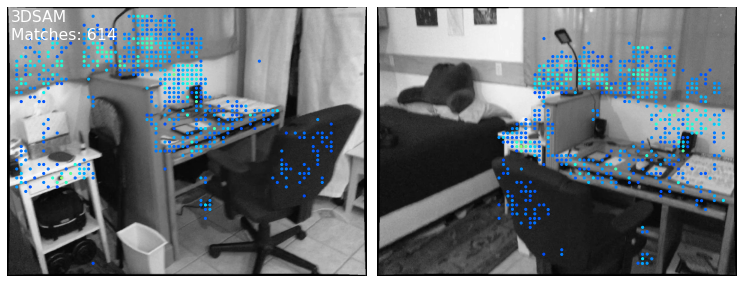

In [51]:
# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

    # Draw
color = cm.jet(mconf)
text = [
    '3DSAM',
    'Matches: {}'.format(len(mkpts0)),
]
last = 0
mkpts0 = mkpts0[last:]
mkpts1 = mkpts1[last:]
color = color[last:]
fig = make_matching_figure(image_grey0[0], image_grey1[0], mkpts0, mkpts1, color, text=text)

In [52]:
H, mask = cv2.findHomography(mkpts0, mkpts1, cv2.RANSAC, 5.0)
pts0 = mkpts0[np.where(mask)[0], :]
pts1 = mkpts1[np.where(mask)[0], :]

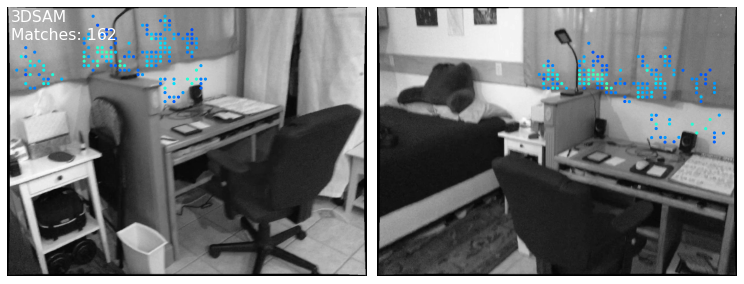

In [53]:
color = cm.jet(mconf)
text = [
    "3DSAM",
    "Matches: {}".format(len(pts0)),
]
color = color[np.where(mask)[0], :]
fig = make_matching_figure(image_grey0[0], image_grey1[0], pts0, pts1, color, text=text)

In [26]:
color.shape

(618, 4)